# Python library : torch_cmif

The torch_cmif library provides a fast implementation the cross mutual information between one real image and one another on PyTorch.
<br />
<br />
<br />
In this library, the paper from J. Öfverstedt et al. has been implemented :
<br />


# References :

- Johan Öfverstedt, Joakim Lindblad, Nataša Sladoje, (2022). Fast computation of mutual information in the frequency domain with applications to global multimodal image alignment, - https://www.sciencedirect.com/science/article/pii/S0167865522001817


<hr />


# Install library


In [1]:
%%bash
if !python -c "import torch_cmif" 2>/dev/null; then
    pip install https://github.com/Simon-Bertrand/FastCMIF-PyTorch/archive/main.zip
fi

# Import library


In [2]:
import torch_cmif

Obtaining file:///home/sbertrand/D%C3%A9veloppement/repos/gits/torch-cmif
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for torch_cmif (pyproject.toml) ... done
  Created wheel for torch_cmif: filename=torch_cmif-0.0.1-0.editable-py3-none-any.whl size=15226 sha256=d747e82187f8d874a980a66681477ba6d4925ca8f63799e2a272c25d89c62424
  Stored in directory: /tmp/pip-ephem-wheel-cache-lkoisnbe/wheels/d3/b2/4f/76de76a0114a7bc162a4b992efd2e64a11f11f227e1a19a6cb
Successfully built torch_cmif
  Attempting uninstall: torch_cmif
    Found existing installation: torch_cmif 0.0.1
    Uninstalling torch_cmif-0.0.1:
      Successfully uninstalled torch_cmif-0.0.1

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install -q matplotlib torchvision
import torch
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## LOAD IMAGE AND TEST IF RANDOM EXTRACTED CENTER POSITIONS ARE CORRECTLY FOUND


Install notebook dependencies


In [4]:
!pip install -q requests
import requests


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Load Mandrill image


In [5]:
import tempfile
import torchvision
import torch.nn.functional as F

with tempfile.NamedTemporaryFile() as fp:
    fp.write(
        requests.get(
            "https://upload.wikimedia.org/wikipedia/commons/a/ab/Mandrill-k-means.png"
        ).content
    )
    im = F.interpolate(
        (
            torchvision.io.read_image(
                fp.name, torchvision.io.ImageReadMode.RGB
            )
            .unsqueeze(0)
            .to(torch.float64)
            .div(255)
        ),
        size=(256, 256),
        mode="bicubic",
        align_corners=False,
    )

Run multiple tests to check if random crop center is correclty found by the ZNCC.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


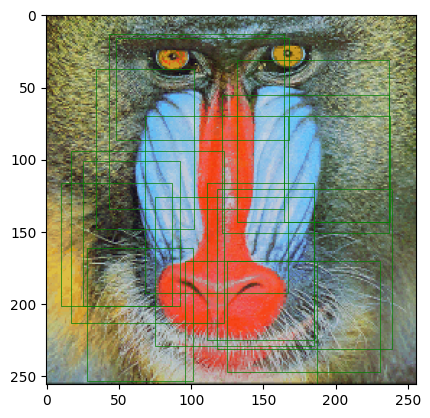

In [6]:
import random

success = 0
failed = 0
pts = []
for _ in range(16):
    imH = random.randint(64, 128)
    imW = random.randint(64, 128)
    i = random.randint(imH // 2 + 1, im.size(-2) - imH // 2 - 1)
    j = random.randint(imW // 2 + 1, im.size(-1) - imW // 2 - 1)

    imT = im[
        :, :, i - imH // 2 : i + imH // 2 + 1, j - imW // 2 : j + imW // 2 + 1
    ]
    if (
        (
            torch_cmif.FastCMIF.findArgmax(
                torch_cmif.FastCMIF(8, "none")(im, imT)
            )
            - torch.Tensor([[[i]], [[j]]])
        ).abs()
        < 3
    ).all():
        pts += [
            dict(
                i=i,
                imH=imH,
                imW=imW,
                j=j,
                success=True,
            )
        ]
        success += 1
    else:
        pts += [
            dict(
                i=i,
                imH=imH,
                imW=imW,
                j=j,
                success=False,
            )
        ]
        failed += 1

plt.imshow(im[0].moveaxis(0, -1))
ax = plt.gca()
for pt in pts:
    ax.add_patch(
        plt.Rectangle(
            (pt["j"] - pt["imW"] // 2, pt["i"] - pt["imH"] // 2),
            pt["imW"],
            pt["imH"],
            edgecolor="g" if pt["success"] else "r",
            facecolor="none",
            linewidth=0.5,
        )
    )

Text(0.5, 1.0, 'CMIF')

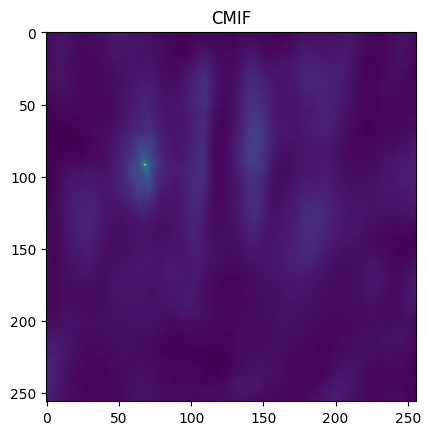

In [7]:
ans = torch_cmif.FastCMIF(8, "sum")(im, imT)
plt.imshow(ans[0].mean(0))
plt.title("CMIF")

In [9]:
%timeit torch_cmif.FastCMIF(8, "sum")(im, imT)

164 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Total errors :


In [8]:
dict(success=success, failed=failed)

{'success': 16, 'failed': 0}